In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
else:
    DATOS_DIR   = '../Datos/' # carpeta donde se encuentran los datasets


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing, metrics, model_selection

from sklearn.model_selection import cross_val_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD

In [3]:
df = pd.read_csv(DATOS_DIR + 'sonar.csv')

# Tomamos todas las columnas menos la última
X = np.array(df.iloc[:, 0:-1])
T = np.array(df.iloc[:,-1])

encoder = preprocessing.LabelEncoder()
T = encoder.fit_transform(T)

# Convertir las categorías en una lista plana
nombres = list(encoder.inverse_transform([0, 1]))
# Imprimir la lista plana de categorías
print(nombres)


['Mine', 'Rock']


In [4]:
#nEj = X.shape[0]

#nomClases = pd.unique(df['class'])
#-- la red tendrá una salida para cada tipo de flor
#salidas = len(nomClases)

#-- la salida debe ser numérica --
#clase = df['class']

#--- CONJUNTOS DE ENTRENAMIENTO Y TESTEO ---
X_train, X_test, T_train, T_test = model_selection.train_test_split( \
        X, T, test_size=0.30) #, random_state=42)

T_trainB = to_categorical(T_train)
T_trainB.shape

(145, 2)

In [5]:
normalizarEntrada = 1  # 1 si normaliza; 0 si no

if normalizarEntrada:
    min_max_scaler = preprocessing.StandardScaler()
    X_train = min_max_scaler.fit_transform(X_train)
    X_test = min_max_scaler.transform(X_test)

### Definición del modelo

In [6]:
nIn = X_train.shape[1]
nOut = T_trainB.shape[1]

model = Sequential()
model.add(Dense(3, input_shape=[nIn], activation='tanh'))
#model.add(Dense(10, activation='tanh'))
model.add(Dense(nOut, activation='softmax'))

model.summary()  #-- muestra la cantidad de parámetros de la red


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 183       
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Configuración para entrenamiento
#-- se utilizará SGD (descenso de gradiente esticástico),
#-- MSE (error cuadrático medio) y ACCURACY como medida de performance
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics='accuracy')


In [8]:
H = model.fit(X_train,T_trainB, epochs=500,verbose=False) #, batch_size=20)

In [9]:
# Calcular el error del modelo
score = model.evaluate(X_train, T_trainB) 
print('Error :', score[0]) 
print('Accuracy:', score[1])

5/5 [==============================] - 0s 2ms/step - loss: 0.4829 - accuracy: 0.8069
Error : 0.4828728437423706
Accuracy: 0.8068965673446655


Text(0, 0.5, 'accuracy')

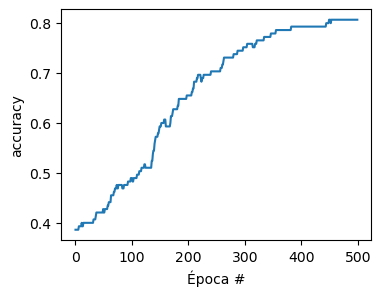

In [10]:
# Evolución del accuracy durante el entrenamiento
metrica = np.array(H.history["accuracy"])

N = np.arange(0, len(metrica))
plt.figure(figsize=(4,3))
plt.plot(N, metrica)
plt.xlabel("Época #")
plt.ylabel("accuracy")

In [11]:
# predecir la salida del modelo
Y_pred = model.predict(X_train)
Y_pred_nro = np.argmax(Y_pred,axis=1)  #-- conversión a entero

print("%% aciertos X_train : %.3f" % metrics.accuracy_score(T_train, Y_pred_nro))


5/5 [==============================] - 0s 2ms/step
% aciertos X_train : 0.807


In [12]:
report = metrics.classification_report(T_train, Y_pred_nro)
print("Confusion matrix Training:\n%s" % report) 

MM = metrics.confusion_matrix(T_train, Y_pred_nro)
print("Confusion matrix:\n%s" % MM)


Confusion matrix Training:
              precision    recall  f1-score   support

           0       0.80      0.86      0.82        77
           1       0.82      0.75      0.78        68

    accuracy                           0.81       145
   macro avg       0.81      0.80      0.80       145
weighted avg       0.81      0.81      0.81       145

Confusion matrix:
[[66 11]
 [17 51]]


5/5 [==============================] - 0s 3ms/step


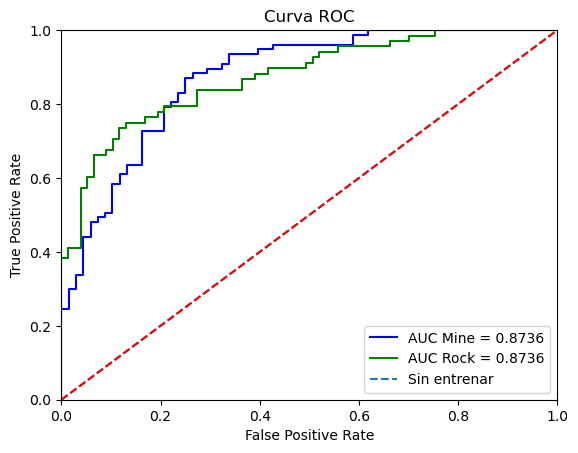

In [13]:
#--- AUC ---
clase_positiva=0  #-- la 1ra. columna corresponde a MINE
Y_pred = model.predict(X_train)
Y_proba = Y_pred[:,clase_positiva]

T_positivo = T_trainB[:,clase_positiva]
fpr, tpr, threshold = metrics.roc_curve(T_positivo, Y_proba)
roc_auc = metrics.auc(fpr, tpr)

clase_negativa=1
Y_probaNeg = Y_pred[:,clase_negativa]
T_negativo = T_trainB[:,clase_negativa]

fprN, tprN, thresholdN = metrics.roc_curve(T_negativo, Y_probaNeg)
roc_aucN = metrics.auc(fprN, tprN)


#Generamos un clasificador sin entrenar , que asignará 0 a todo
siempre_0 = np.zeros(T_positivo.shape)
ns_fpr, ns_tpr, _ = metrics.roc_curve(T_positivo,siempre_0)


# method I: plt
plt.figure()
plt.title('Curva ROC')            # - Clase positiva: '+ nombres[clase_positiva])
plt.plot(fpr, tpr, 'b', label = 'AUC Mine = %0.4f' % roc_auc)
plt.plot(fprN, tprN, 'g', label = 'AUC Rock = %0.4f' % roc_aucN)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

5/5 [==============================] - 0s 1ms/step
AUC-PR: 0.878739480187217


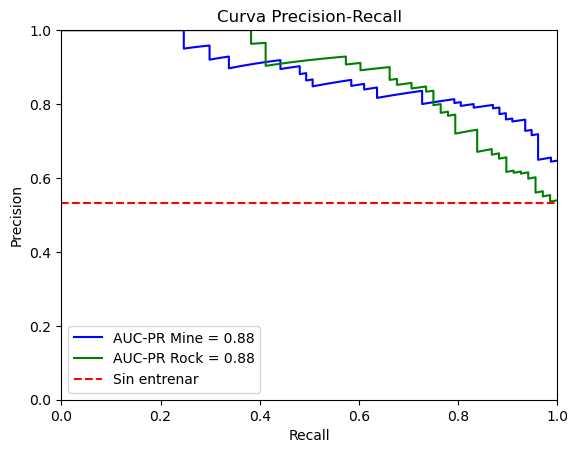

In [14]:
Y_pred = model.predict(X_train)

## Curva PR
clase_positiva=0  #-- 0 = 'Mine';  1 = 'Rock'
Y_proba = Y_pred[:,clase_positiva]
T_positivo = T_trainB[:,clase_positiva]

# Calcula la curva de precisión y recall
precision, recall, threshold = metrics.precision_recall_curve(T_positivo, Y_proba)

# Calcula el área bajo la curva de precisión y recall (AUC-PR)
pr_auc = metrics.auc(recall, precision)

clase_negativa=1  #-- 0 = 'Mine';  1 = 'Rock'
Y_probaNeg = Y_pred[:,clase_negativa]
T_negativo = T_trainB[:,clase_negativa]

# Calcula la curva de precisión y recall
precisionN, recallN, thresholdN = metrics.precision_recall_curve(T_negativo, Y_probaNeg)

# Calcula el área bajo la curva de precisión y recall (AUC-PR)
pr_aucN = metrics.auc(recallN, precisionN)


# Imprime el AUC-PR
print("AUC-PR:", pr_auc)

# Tasa de acierto si se responde simpere por la clase positiva
nUnos = np.sum(T_positivo)/len(T_positivo)

# Grafica la curva de precisión y recall
plt.figure()
plt.title('Curva Precision-Recall')           # - Clase positiva: '+ nombres[clase_positiva])
plt.plot(recall, precision, 'b', label = 'AUC-PR Mine = %0.2f' % pr_auc)
plt.plot(recallN, precisionN, 'g', label = 'AUC-PR Rock = %0.2f' % pr_aucN)
plt.plot([0,1], [nUnos,nUnos], 'r--', label='Sin entrenar')
plt.legend(loc = 'lower left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()